In [8]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F

from utils.system import AAC as aac
from utils.controller import LCBF, PID
from utils.dataset import Dataset
from utils.estimator import *


In [2]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return np.array([p0, v0, z0])

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

In [3]:
dt = 0.01
simTime = 50

# Real parameters
v_lead = 22
v_des = 25
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0.
v0 = 22
z0 = 35


x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

# Parameter ELM
n_hidden = 50


In [4]:
aac = AAC(m, c_d, f0, f1, f2, v_lead)
'
cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

derivator = Derivator(dt)

learned_ratio = 1.6
estimator = OSELM_nonaffine(4, n_hidden, 1, learned_ratio, dt)

xs = []
us = []
Vs = []
hs = []
dhe_reals = []
dhes = []

slacks = []

weights = 0.2

train_input, train_output = [], []

train_input_x, train_input_u, train_output = [], [], []

x = sample_initial_state()


first_time = True

# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)'

if simTime / dt < learned_ratio*n_hidden:
    raise ValueError('simTime / dT: {} must be larger than n_hidden: {}'.format(simTime / dt, n_hidden))

pbar = tqdm(total=simTime/dt)

for t in np.arange(0, simTime, dt): #simTime
    pbar.update(n=1)

    # Get reference control
    e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
    u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
    u_ref = u_ref[0,0]
    
    aac.v_lead = v_lead #+ 5*np.sin(2*t)
    cont.v_lead =  v_lead #+ 5*np.sin(2*t)
    
    
    k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t) 
        

    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)

    dh_real = derivator.update(h)

    dhe_real = dh_real - dh

    estimator.training(x, k/5000, dhe_real, t)


    xs.append(x)
    us.append(k)
    Vs.append(V)
    hs.append(h)
    dhes.append(dhe)
    dhe_reals.append(dhe_real)
    slacks.append(slack_sol)
    
    x = x_n
        
        


  0%|          | 0/5000.0 [00:00<?, ?it/s]

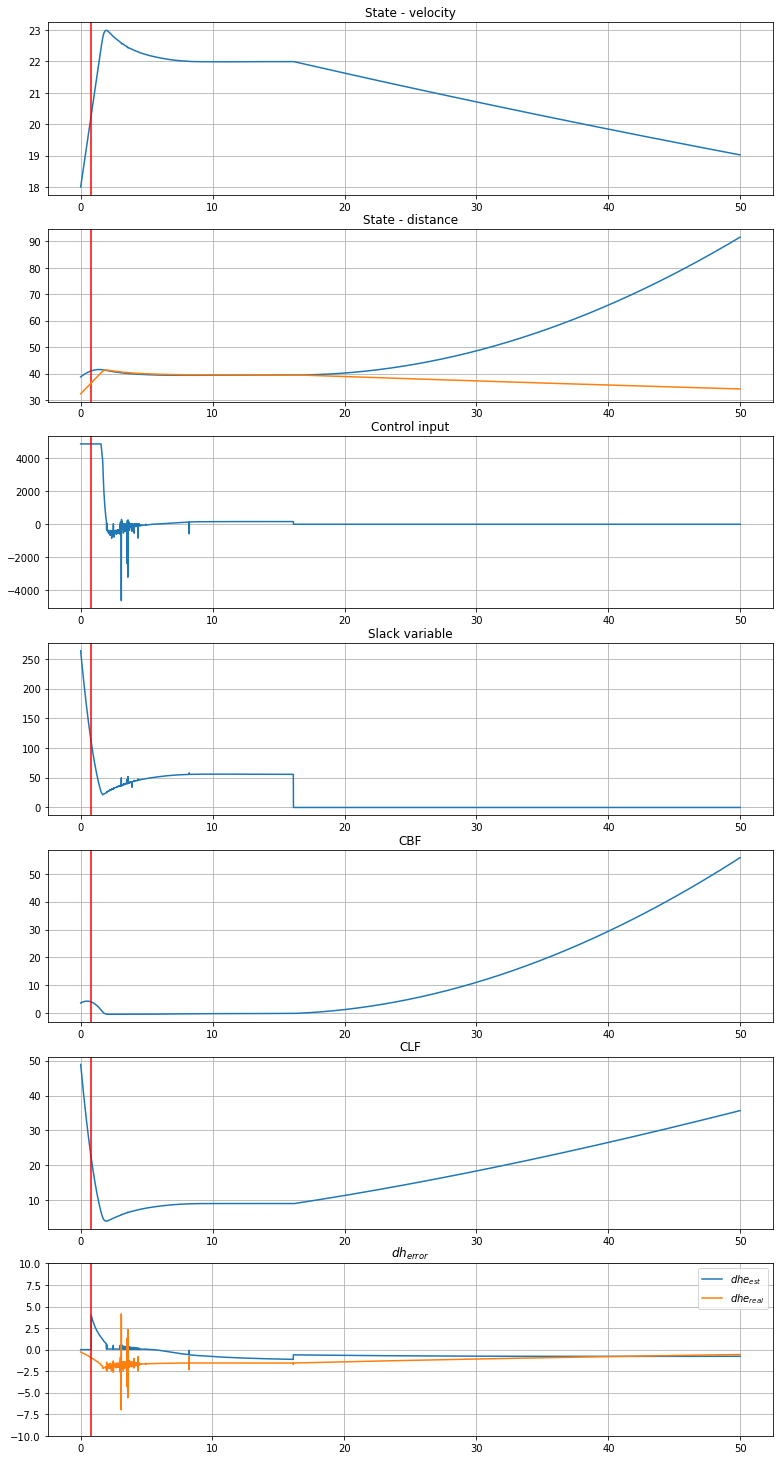

In [ ]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')
ax[2].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')
ax[3].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[4].plot(t_lns, hs)
ax[4].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dhes[1:])
ax[6].plot(t_lns[1:], dhe_reals[1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])
